# GP Regression with numpyro

http://num.pyro.ai/en/stable/examples/gp.html

In [1]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_feasible, init_to_median, init_to_sample, init_to_uniform, init_to_value


In [2]:
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

## Artificial data generation 

In [3]:
# create artificial regression dataset
def get_data(N=30, sigma_obs=0.15, N_test=400):
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    Y += sigma_obs * np.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = jnp.linspace(-1.3, 1.3, N_test)

    return X, Y, X_test

In [4]:
X_, Y_, _ = get_data(N=200, sigma_obs=1E-9)

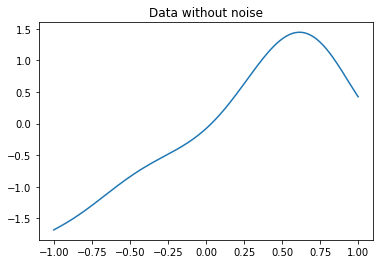

In [5]:
plt.plot(X_, Y_); plt.title('Data without noise');

## Observation

In [6]:
X, Y, X_test = get_data(N=11)

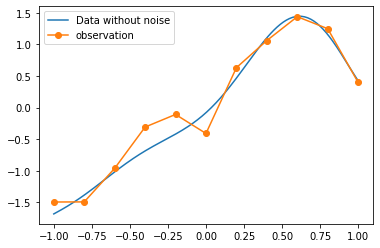

In [7]:
plt.plot(X_, Y_, label='Data without noise');
plt.plot(X, Y, 'o-', label='observation');
plt.legend();

## build up a model
- Covariance Kernel is modeled using a squared exponential together with additiv observation noise 
$$
    k(x,z) = v\exp\bigg(
        -\frac{(x-z)^2}{2l^2}
    \bigg)
    +
    \eta*\delta_{xz} \quad\quad v, l, \eta > 0
$$
where
- $v$: controls the magnitude of the sq. exponential
- $l$: controls the size of the correlation along the domain of $x$
- $\eta$: is the model parameter to decide the observation noise.

In [8]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k
#

def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", 
                   dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), 
                                            covariance_matrix=k),
                   obs=Y)
#

### LogNormal distribution
- The logarithm of samples follow normal distribution

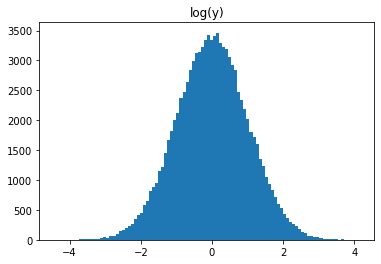

In [9]:
rng_key = random.PRNGKey(0)
with numpyro.handlers.seed(rng_seed=rng_key):
    y = numpyro.sample('y', dist.LogNormal(0., 1.), sample_shape=(100000,))
plt.hist(jnp.log(y), bins=100); plt.title('log(y)');

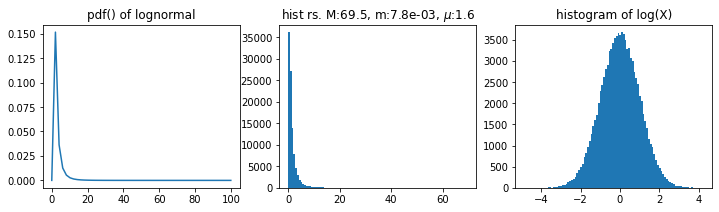

In [10]:
x = np.linspace(0, 100)
lognorm = stats.lognorm(s=1., loc=0)  # std of log is 1
rs = lognorm.rvs(100000)

fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(x, lognorm.pdf(x)); axes[0].set(title='pdf() of lognormal')
axes[1].hist(rs, bins=100); axes[1].set(title=f'hist rs. M:{rs.max():.1f}, m:{rs.min():.1e}, $\mu$:{rs.mean():.1f}')
axes[2].hist(np.log(rs), bins=100); axes[2].set(title='histogram of log(X)');

## MCMC Inference

In [11]:
mcmc = MCMC(NUTS(model),
           num_warmup=1000,
           num_samples=2000)
mcmc.run(rng_key, X, Y)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 481.96it/s, 23 steps of size 5.65e-02. acc. prob=0.81] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length     21.24    482.23      0.43      0.00      1.29   1438.19      1.00
   kernel_noise      0.14      0.22      0.07      0.00      0.28    215.12      1.00
     kernel_var     18.19    348.96      1.10      0.00      5.29   1158.56      1.00

Number of divergences: 12


## Prediction

In [12]:
X_test.shape

(400,)

In [13]:
# test for a posterior sample
var = samples['kernel_var'][0]
length = samples['kernel_length'][0]
noise = samples['kernel_noise'][0]
print(var, length, noise)

# compute kernels between train and test data, etc.
k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
k_XX = kernel(X, X, var, length, noise, include_noise=True)
K_xx_inv = jnp.linalg.inv(k_XX)
# posterior covariance
K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))  
# posterior mean
mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))  
# we return both the mean function and a sample from the posterior predictive for the
# given set of hyperparameters
sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])


0.34875274 0.17186989 0.02244429


In [14]:
# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    # posterior covariance
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))  
    # posterior mean
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))  
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])
    pp_sample = mean + sigma_noise
    #
    return mean, pp_sample

In [15]:
# do prediction
vmap_args = (random.split(rng_key_predict, samples['kernel_var'].shape[0]),
             samples['kernel_var'], samples['kernel_length'], samples['kernel_noise'])
means, predictions = vmap(lambda rng_key, var, length, noise:
                          predict(rng_key, X, Y, X_test, var, length, noise))(*vmap_args)

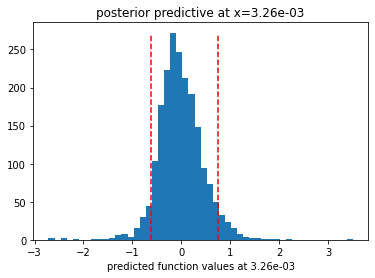

In [16]:
# We examine the prediction result at X_test[200]
i=200
perc90 = np.percentile(predictions[:,i], [5., 95.])
plt.hist(predictions[:,i], bins=50); plt.title(f'posterior predictive at x={X_test[i]:.2e}')
plt.vlines(perc90, ymin=0, ymax=269, linestyles='dashed', colors='r');
plt.xlabel(f'predicted function values at {X_test[i]:.2e}');

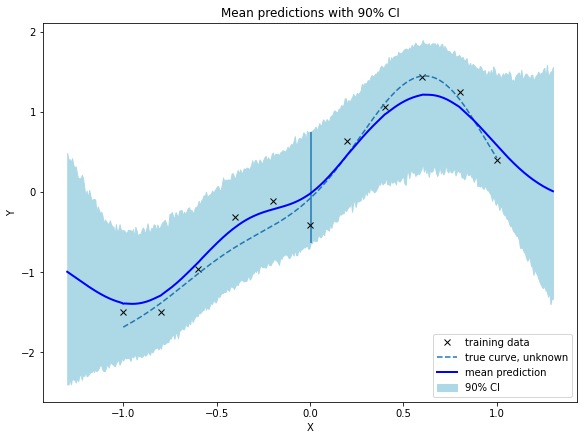

In [17]:
mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(X, Y, 'kx', label='training data')
ax.plot(X_, Y_, '--', label='true curve, unknown')
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color='lightblue', label='90% CI')
# plot mean prediction
ax.plot(X_test, mean_prediction, 'blue', ls='solid', lw=2.0, label='mean prediction')
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI"); 
ax.legend(loc='lower right');

ax.vlines(x=X_test[i], ymin=perc90[0], ymax=perc90[1]);

End.

## Various Prior Distributions

In [46]:
def model_exp(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.Exponential(rate=1./3))
    noise = numpyro.sample("kernel_noise", dist.Exponential(rate=1./3))
    length = numpyro.sample("kernel_length", dist.Exponential(rate=1./3))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", 
                   dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), 
                                            covariance_matrix=k),
                   obs=Y)

In [47]:
rng_key, rng_key_predict = random.split(rng_key)

mcmc = MCMC(NUTS(model_exp),
           num_warmup=1000,
           num_samples=2000)

mcmc.run(rng_key, X, Y)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:39<00:00, 75.27it/s, 7 steps of size 5.63e-01. acc. prob=0.92] 


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.52      0.08      0.52      0.39      0.64   1258.23      1.00
   kernel_noise      0.04      0.00      0.04      0.03      0.05   1382.24      1.00
     kernel_var      2.07      1.56      1.64      0.34      4.06   1298.74      1.00

Number of divergences: 0


In [68]:
def model_uniform(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.Uniform(low=0., high=30))
    noise = numpyro.sample("kernel_noise", dist.Uniform(low=0., high=30))
    length = numpyro.sample("kernel_length", dist.Uniform(low=0., high=30))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", 
                   dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), 
                                            covariance_matrix=k),
                   obs=Y)

In [69]:
rng_key, rng_key_predict = random.split(rng_key)

mcmc = MCMC(NUTS(model_uniform),
           num_warmup=1000,
           num_samples=2000)

mcmc.run(rng_key, X, Y)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:47<00:00, 62.63it/s, 11 steps of size 4.58e-01. acc. prob=0.91]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.57      0.10      0.57      0.40      0.74    772.52      1.00
   kernel_noise      0.04      0.01      0.04      0.03      0.05   1256.47      1.00
     kernel_var      5.44      5.71      3.24      0.29     13.60    764.33      1.00

Number of divergences: 0


## Init Method Comparison

In [22]:
rng_key, rng_key_predict = random.split(rng_key)

mcmc = MCMC(NUTS(model),
           num_warmup=1000,
           num_samples=2000)
mcmc.run(rng_key, X, Y)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 483.12it/s, 3 steps of size 3.40e-01. acc. prob=0.79]  


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length   2985.29 101798.47      0.38      0.00      1.29   1942.70      1.00
   kernel_noise      0.17      0.38      0.05      0.00      0.37     48.32      1.04
     kernel_var      3.80     25.42      1.01      0.00      4.60    351.73      1.00

Number of divergences: 101


In [23]:
rng_key, rng_key_predict = random.split(rng_key)

mcmc = MCMC(NUTS(model, init_strategy=init_to_sample()),
           num_warmup=1000,
           num_samples=2000)
mcmc.run(rng_key, X, Y)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 462.27it/s, 3 steps of size 4.13e-02. acc. prob=0.86]  


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length 434950.88 8933848.00      0.43      0.00      1.74    926.90      1.00
   kernel_noise      0.17      0.33      0.08      0.01      0.31    104.18      1.01
     kernel_var    101.78   2668.35      1.04      0.00      5.60    781.79      1.00

Number of divergences: 2


In [24]:
rng_key, rng_key_predict = random.split(rng_key)

mcmc = MCMC(NUTS(model, init_strategy=init_to_uniform()),
           num_warmup=1000,
           num_samples=2000)
mcmc.run(rng_key, X, Y)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 475.45it/s, 7 steps of size 2.18e-01. acc. prob=0.88]   


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length 170728512.00 5187442688.00      0.39      0.00      1.32    925.89      1.00
   kernel_noise      0.15      0.29      0.06      0.00      0.29     35.59      1.04
     kernel_var      5.66     33.85      0.94      0.00      4.15    236.43      1.01

Number of divergences: 27


In [25]:
rng_key, rng_key_predict = random.split(rng_key)

mcmc = MCMC(NUTS(model, init_strategy=init_to_feasible()),
           num_warmup=1000,
           num_samples=2000)
mcmc.run(rng_key, X, Y)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 482.45it/s, 31 steps of size 7.28e-02. acc. prob=0.78] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length 345854.94 14917693.00      0.34      0.00      1.09   2001.30      1.00
   kernel_noise      0.10      0.24      0.04      0.00      0.21     85.62      1.06
     kernel_var     15.50    303.55      0.93      0.00      4.75    572.57      1.00

Number of divergences: 153


In [26]:
rng_key, rng_key_predict = random.split(rng_key)

mcmc = MCMC(NUTS(model_exp, init_strategy=init_to_feasible()),
           num_warmup=1000,
           num_samples=2000)
mcmc.run(rng_key, X, Y)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:05<00:00, 541.76it/s, 7 steps of size 4.49e-01. acc. prob=0.93]  



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.42      0.19      0.38      0.16      0.70   1015.23      1.00
   kernel_noise      0.14      0.13      0.10      0.01      0.30    840.23      1.00
     kernel_var      0.68      0.35      0.62      0.20      1.18   1139.47      1.00

Number of divergences: 0


---
With many data points

## Observation

In [27]:
X, Y, X_test = get_data(N=50)

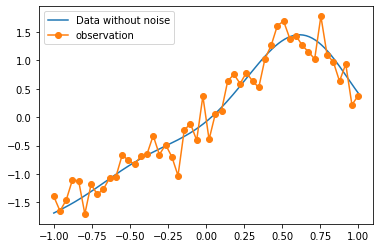

In [28]:
plt.plot(X_, Y_, label='Data without noise');
plt.plot(X, Y, 'o-', label='observation');
plt.legend();

## MCMC Inference

In [29]:
rng_key, rng_key_predict = random.split(rng_key)

mcmc = MCMC(NUTS(model_exp),
           num_warmup=1000,
           num_samples=2000)

mcmc.run(rng_key, X, Y)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:13<00:00, 229.72it/s, 7 steps of size 5.54e-01. acc. prob=0.95]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.42      0.08      0.42      0.29      0.55   1248.44      1.00
   kernel_noise      0.07      0.02      0.07      0.05      0.10   1405.31      1.00
     kernel_var      0.72      0.33      0.66      0.26      1.19   1514.92      1.00

Number of divergences: 0


In [30]:
mcmc = MCMC(NUTS(model),
           num_warmup=1000,
           num_samples=2000)
mcmc.run(rng_key, X, Y)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:14<00:00, 201.89it/s, 7 steps of size 4.31e-01. acc. prob=0.95] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.50      0.12      0.49      0.31      0.66    805.46      1.00
   kernel_noise      0.07      0.02      0.07      0.05      0.09   1239.61      1.00
     kernel_var      2.37      4.28      1.26      0.23      4.65    716.01      1.00

Number of divergences: 0


## Prediction

In [31]:
# do prediction
vmap_args = (random.split(rng_key_predict, samples['kernel_var'].shape[0]),
             samples['kernel_var'], samples['kernel_length'], samples['kernel_noise'])
means, predictions = vmap(lambda rng_key, var, length, noise:
                          predict(rng_key, X, Y, X_test, var, length, noise))(*vmap_args)

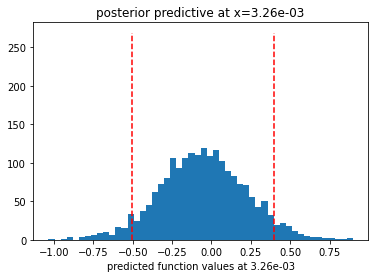

In [32]:
# We examine the prediction result at X_test[200]
i=200
perc90 = np.percentile(predictions[:,i], [5., 95.])
plt.hist(predictions[:,i], bins=50); plt.title(f'posterior predictive at x={X_test[i]:.2e}')
plt.vlines(perc90, ymin=0, ymax=269, linestyles='dashed', colors='r');
plt.xlabel(f'predicted function values at {X_test[i]:.2e}');

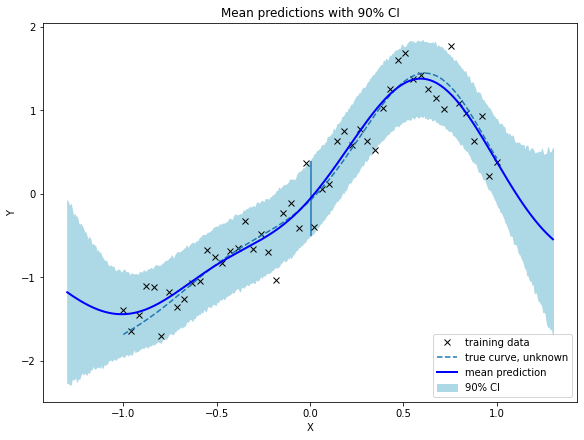

In [33]:
mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(X, Y, 'kx', label='training data')
ax.plot(X_, Y_, '--', label='true curve, unknown')
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color='lightblue', label='90% CI')
# plot mean prediction
ax.plot(X_test, mean_prediction, 'blue', ls='solid', lw=2.0, label='mean prediction')
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI"); 
ax.legend(loc='lower right');

ax.vlines(x=X_test[i], ymin=perc90[0], ymax=perc90[1]);

## Observation

In [34]:
X, Y, X_test = get_data(N=150)

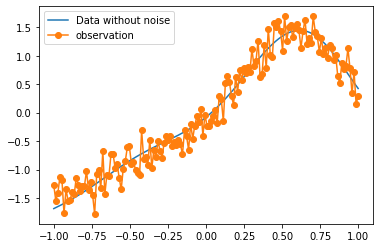

In [35]:
plt.plot(X_, Y_, label='Data without noise');
plt.plot(X, Y, 'o-', label='observation');
plt.legend();

## MCMC Inference

In [48]:
rng_key, rng_key_predict = random.split(rng_key)

mcmc = MCMC(NUTS(model_exp),
           num_warmup=1000,
           num_samples=2000)

mcmc.run(rng_key, X, Y)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:42<00:00, 71.27it/s, 7 steps of size 5.63e-01. acc. prob=0.93]  



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.52      0.08      0.52      0.39      0.64   1047.24      1.00
   kernel_noise      0.04      0.01      0.04      0.04      0.05   1177.68      1.00
     kernel_var      2.07      1.55      1.64      0.32      4.10   1003.85      1.00

Number of divergences: 0


In [49]:
mcmc = MCMC(NUTS(model),
           num_warmup=1000,
           num_samples=2000)
mcmc.run(rng_key, X, Y)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:47<00:00, 63.42it/s, 7 steps of size 4.68e-01. acc. prob=0.95] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.49      0.08      0.49      0.36      0.62    935.08      1.00
   kernel_noise      0.04      0.01      0.04      0.03      0.05   1340.78      1.00
     kernel_var      1.90      2.66      1.23      0.26      3.67    975.96      1.00

Number of divergences: 0


## Prediction

In [70]:
# do prediction
vmap_args = (random.split(rng_key_predict, samples['kernel_var'].shape[0]),
             samples['kernel_var'], samples['kernel_length'], samples['kernel_noise'])
means, predictions = vmap(lambda rng_key, var, length, noise:
                          predict(rng_key, X, Y, X_test, var, length, noise))(*vmap_args)

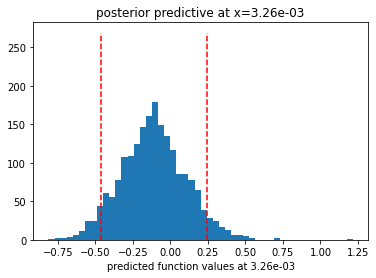

In [71]:
# We examine the prediction result at X_test[200]
i=200
perc90 = np.percentile(predictions[:,i], [5., 95.])
plt.hist(predictions[:,i], bins=50); plt.title(f'posterior predictive at x={X_test[i]:.2e}')
plt.vlines(perc90, ymin=0, ymax=269, linestyles='dashed', colors='r');
plt.xlabel(f'predicted function values at {X_test[i]:.2e}');

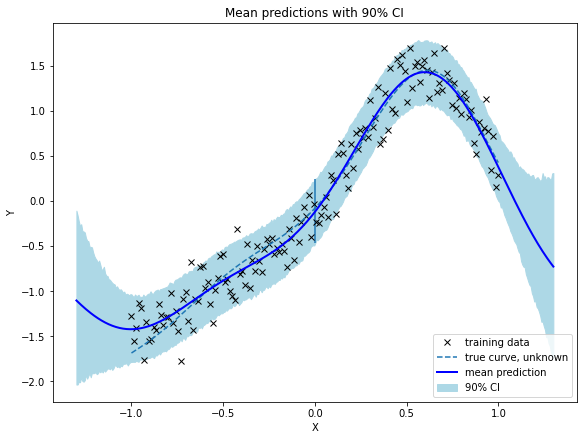

In [72]:
mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(X, Y, 'kx', label='training data')
ax.plot(X_, Y_, '--', label='true curve, unknown')
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color='lightblue', label='90% CI')
# plot mean prediction
ax.plot(X_test, mean_prediction, 'blue', ls='solid', lw=2.0, label='mean prediction')
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI"); 
ax.legend(loc='lower right');

ax.vlines(x=X_test[i], ymin=perc90[0], ymax=perc90[1]);

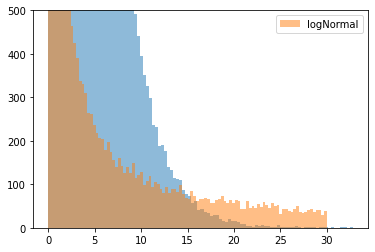

In [67]:
rng_key = random.PRNGKey(0)
with numpyro.handlers.seed(rng_seed=rng_key):
    y = numpyro.sample('y', dist.Exponential(1./3.), sample_shape=(100000,))
    yln = numpyro.sample('y', dist.LogNormal(0., 10.), sample_shape=(100000,))
plt.hist(y, bins=100, alpha=.5);
plt.hist(yln, bins=100, range=[0,30], alpha=.5, label='logNormal'); 
plt.ylim((0,500))
plt.legend();
#plt.xlim([0,100])